In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data explore

In [26]:
raw_data = pd.read_csv("winemag-data-130k-v2.csv").drop("Unnamed: 0", axis = 1)
raw_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [27]:
raw_data.loc[raw_data.iloc[:, 12].isna()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


In [28]:
np.shape(raw_data)

(129971, 13)

In [29]:
# Clean up
data_drop = pd.DataFrame(raw_data.drop(["designation", "region_1", "region_2", "taster_name", "taster_twitter_handle", "title", "winery"], axis = 1))

In [30]:
clean_data = pd.DataFrame(data_drop.dropna().drop_duplicates().reset_index(drop = True))

In [31]:
clean_data.head()

,country,description,points,price,province,variety
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red
1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris
2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling
3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot


In [32]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111534 entries, 0 to 111533
Data columns (total 6 columns):
country        111534 non-null object
description    111534 non-null object
points         111534 non-null int64
price          111534 non-null float64
province       111534 non-null object
variety        111534 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


## Visualization 1 & 2

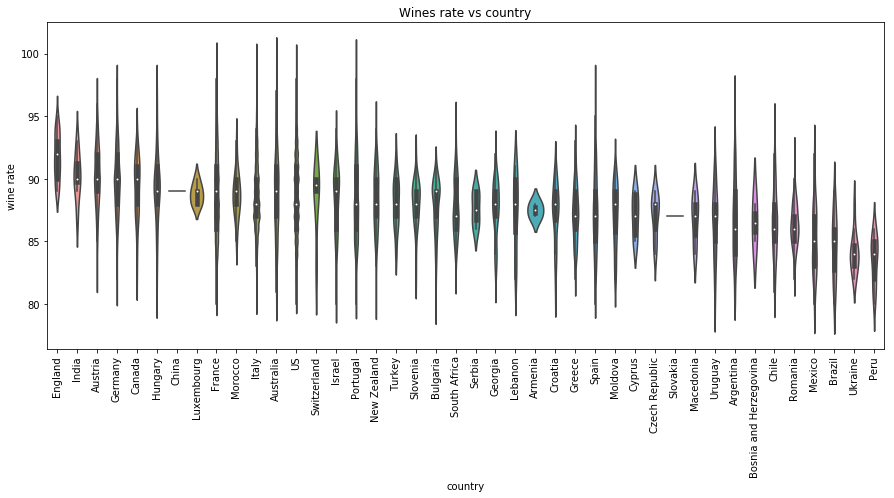

In [33]:
plt.figure(figsize = (15, 6))
order = clean_data.groupby("country")["points"].mean().sort_values(ascending = False).index
violin_plot = sns.violinplot(data = clean_data, x = "country", y = "points", order = order)
violin_plot.set_xticklabels(labels = violin_plot.get_xticklabels(), rotation = 90)
violin_plot.set_ylabel("wine rate")
violin_plot.set_title("Wines rate vs country")
plt.show()

The violin plot show the distribution of wine rate(column "# point" in the csv file) of each country. The mark is areas and the channels are position and area. I show this plot in descending order by the mean wine rate. Countries are encoded using the position on x-axis. The area of violin chart show the distribution of wine rate.I noticed that there are two countries only have line in the vionlin plot. That means only one type of wine is recorded in this dataset. This plot shows that wines from England have the highest mean wine rate.

C:\Users\ericl\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


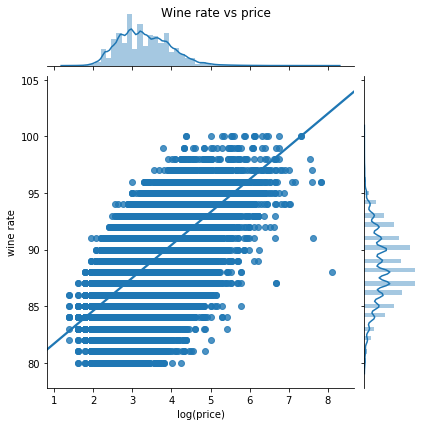

In [34]:
g = sns.JointGrid(x = np.log(clean_data["price"]), y = clean_data["points"])
g.set_axis_labels("log(price)", "wine rate")
g = g.plot(sns.regplot, sns.distplot)
g.fig.suptitle("Wine rate vs price")
plt.show()

This is a visualization that conbine scatter chart, bar chart and line chart. The marks are lines and points. The channels are position and length. First, the scatter plot show the distribution and correlation between wine rate and price. I transform price variable into log(price) then it shows wine rate has a positive relationship with price. The bar charts on right and top show the distribution of log(price) and wine rate. The wine rate is a normal distribution and the price is a chi-square distribution. I noticed that the wine rate is no consistent, there are gaps in the wine rate.

## Data preprocessing

In [63]:
# One hot encoding
sampled_data = clean_data.sample(n = 30000).reset_index(drop = True)
encoded_data = pd.get_dummies(sampled_data, columns = ["country", "province", "variety"])

In [64]:
%%time
# Text preprocessing
stop_word = stopwords.words("english")
for i in range(len(encoded_data)):
    raw_text = encoded_data.loc[i, "description"]
    stemmed_word = []
    for word in nltk.word_tokenize(raw_text):
        if(word.isalpha() and word not in stop_word):
            stemmed_word.append(PorterStemmer().stem(word.lower()))
    encoded_data.loc[i, "description"] = " ".join(stemmed_word)
    if(i % 5000 == 0):
        print(i)

0
5000
10000
15000
20000
25000
Wall time: 2min 14s


In [66]:
# Split trian and test set
train, test = train_test_split(encoded_data, train_size = 0.8, test_size = 0.2, random_state = 0)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [137]:
# Standardization
scaler = StandardScaler().fit(train.loc[:, ["price", "points"]])
train.loc[:, ["price", "points"]]= scaler.transform(train.loc[:, ["price", "points"]])
test.loc[:, ["price", "points"]] = scaler.transform(test.loc[:, ["price", "points"]])
X_train = pd.DataFrame(train.drop("points", axis = 1))
X_test = pd.DataFrame(test.drop("points", axis = 1))
y_train = pd.Series(train["points"])
y_test = pd.Series(test["points"])

In [138]:
# Tf-idf and LDA
tf_idf = tfidf(sublinear_tf = True).fit(X_train["description"])
train_description = tf_idf.transform(X_train["description"])
test_description = tf_idf.transform(X_test["description"])
lda = LDA(n_components = 10).fit(train_description)
train_description = lda.transform(train_description)
test_description = lda.transform(test_description)

C:\Users\ericl\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [139]:
for i in range(np.shape(train_description)[1]):
    X_train[str(i+1)] = train_description[:, i]
for i in range(np.shape(test_description)[1]):
    X_test[str(i+1)] = test_description[:, i]
X_train_array = X_train.drop("description", axis = 1).values
X_test_array = X_test.drop("description", axis = 1).values

I only use "country", "description", "price", "province", "variety" as features. Region_1, Region_2 are removed because they have too many NA values. "taster name", "taster_twitter_handle" are removed because they have high correlation and provide limited information to the "points". "designation", "winery", "title" have too many unique values and may cause overfitting, so they are also removed from the data. After remove all those columns and drop all the entries with NA, standard NLP preprocessing methods were applied to "description" columns(remove stop words, stemming). Then I apply tf-idf method on "description" columns and use LDA to select the top 10 words. I also use one hot encoding method on categorical features and standardization on continuous features. Since the text preprocessing and modeling need a long time to run on my computer, I have to on a subset of the data that have 25%(30K) of data point.

## Modeling

### Lasso Regression

In [112]:
%%time
lasso_scores_list = []
for i in range(1,21):
    lasso = Lasso(alpha = i/10)
    scores = cross_val_score(lasso, X_train_array, y_train, cv = 10, scoring = "neg_mean_squared_error")
    lasso_scores_list.append(np.sqrt(np.abs(scores)))
    if(i % 10 == 0):
        print(i)

10
20
Wall time: 3min 3s


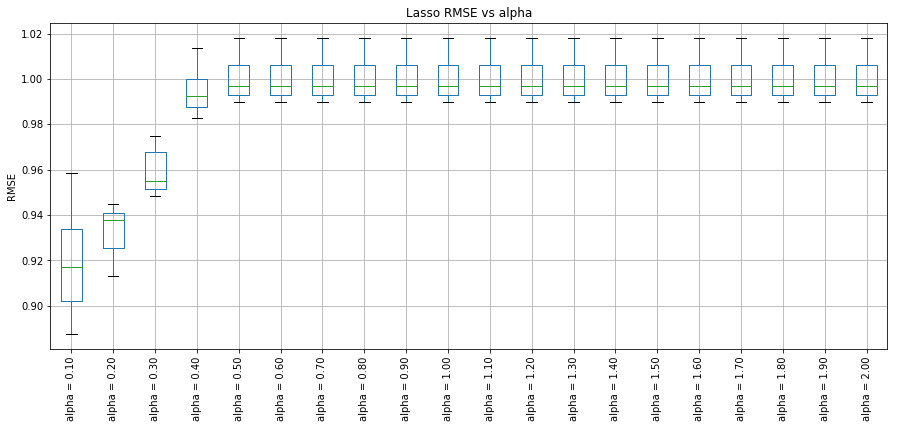

In [121]:
lasso_scores_df = pd.DataFrame()
for score, alpha in zip(lasso_scores_list, range(1, 21)):
    lasso_scores_df["alpha = %.2f" % (alpha / 10)] = score
axes = lasso_scores_df.boxplot(figsize = (15, 6), rot = 90)
axes.set_ylabel("RMSE")
axes.set_title("Lasso RMSE vs alpha")
plt.show()

### Ridge Regression

In [109]:
%%time
ridge_scores_list = []
for i in range(40, 100, 2):
    ridge = Ridge(alpha = i/10)
    scores = cross_val_score(ridge, X_train_array, y_train, cv = 10, scoring = "neg_mean_squared_error")
    ridge_scores_list.append(np.sqrt(np.abs(scores)))
    if(i % 10 == 0):
        print(i)

40
50
60
70
80
90
Wall time: 11min 58s


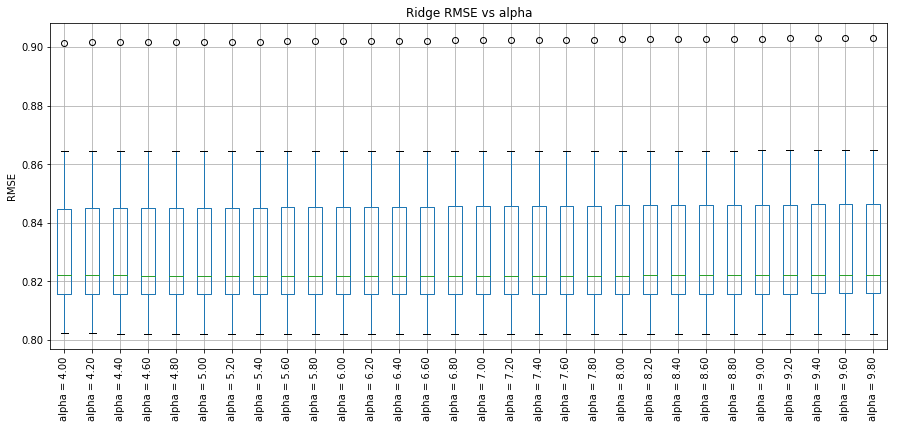

In [122]:
ridge_scores_df = pd.DataFrame()
for score, alpha in zip(ridge_scores_list, range(40, 100, 2)):
    ridge_scores_df["alpha = %.2f" % (alpha / 10)] = score
axes = ridge_scores_df.boxplot(figsize = (15, 6), rot = 90)
axes.set_ylabel("RMSE")
axes.set_title("Ridge RMSE vs alpha")
plt.show()

### Random Forest Regression

In [113]:
%%time
RFR_scores_list = []
for i in range(10, 110, 10):
    RFR = RandomForestRegressor(n_estimators = i)
    scores = cross_val_score(RFR, X_train_array, y_train, cv = 10, scoring = "neg_mean_squared_error")
    RFR_scores_list.append(np.sqrt(np.abs(scores)))
    print(i)

10
20
30
40
50
60
70
80
90
100
Wall time: 1h 8min 30s


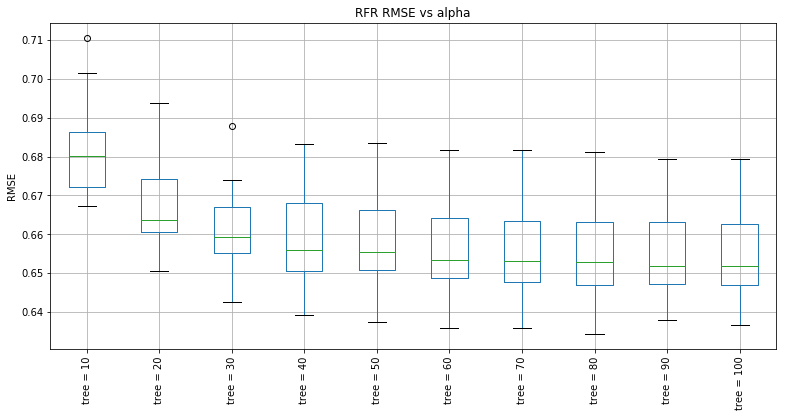

In [126]:
RFR_scores_df = pd.DataFrame()
for score, tree in zip(RFR_scores_list, range(10, 110, 10)):
    RFR_scores_df["tree = %d" % tree] = score
axes = RFR_scores_df.boxplot(figsize = (13, 6), rot = 90)
axes.set_ylabel("RMSE")
axes.set_title("RFR RMSE vs alpha")
plt.show()

I use boxplot to show all the result of 10-fold cv. The data have one categorical value attribute and one quantitative value attribute. These 3 charts encode the categorical values with horizontal positions and express the distribution of quantitative values of each category and the trends of the data. The task is to find the best hyperparameters for each model. In the charts, the smaller RMSE, the better the result. The best alpha for Lasso is alpha = 0.1. Ridge model is weird, all the alpha provide almost the same result. So for that reason, I choice alpha = 4 as the best alpha. The result of Random Forest is the best. From the boxplot, n_estimators = 100 is the best parameter. However, Random Forest need a lot of time to run, so I choice n_estimators = 90 as the best parameter

### Test set

In [127]:
lasso = Lasso(alpha = 0.1)
ridge = Ridge(alpha = 40)
RFR = RandomForestRegressor(n_estimators = 90)

In [140]:
%%time
# Lasso
lasso.fit(X_train_array, y_train)
lasso_y_predict = lasso.predict(X_test_array)
# Ridge
ridge.fit(X_train_array, y_train)
ridge_y_predict = ridge.predict(X_test_array)
# Random Forest
RFR.fit(X_train_array, y_train)
RFR_y_predict = RFR.predict(X_test_array)

Wall time: 1min 14s


In [141]:
print("Lasso Regression Test RMSE: %.2f" % np.sqrt(mean_squared_error(lasso_y_predict, y_test)))
print("Ridge Regression Test RMSE: %.2f" % np.sqrt(mean_squared_error(ridge_y_predict, y_test)))
print("RFR Regression Test RMSE: %.2f" % np.sqrt(mean_squared_error(RFR_y_predict, y_test)))

Lasso Regression Test RMSE: 0.90
Ridge Regression Test RMSE: 0.83
RFR Regression Test RMSE: 0.67


Random Forest Regression has the smallest RMSE so it has the best performance on test dataset.

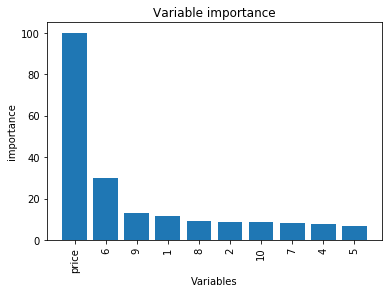

In [162]:
feature_importance = RFR.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())
sorted_feature = np.flip(np.argsort(feature_importance)[-10:], axis = 0)
pos = np.arange(10)
plt.bar(pos, feature_importance[sorted_feature])
plt.xticks(pos, np.array(X_test.drop("description", axis = 1).columns)[sorted_feature], rotation = 90)
plt.ylabel("importance")
plt.xlabel("Variables")
plt.title("Variable importance")
plt.show()

I use bar plot to show the variable importance. The numbers on x-axis are actually the result of tf-idf. The mark is line. The channel are positions and length of bars. From this chart we can see that the price is the most importance variable. Then the rest importance variables are all from description, so the description play an importance role in this model.